# Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network

In this notebook we reproduce some results of the Super Resolution paper [1] in PyTorch.

[1] Ledig, C., Theis, L., Huszár, F., Caballero, J., Cunningham, A., Acosta, A., ... & Shi, W. (2017). Photo-realistic single image super-resolution using a generative adversarial network. In _Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4681-4690)_.

## Pre-processing: Loading datasets
In a first step we download all the required datasets.

In [ ]:
import requests

url_91 = ("https://drive.google.com/uc?export=download&id=1eVfd2Snh5bCl0ulMsRE4ker_p-o1M_lm")
url_set5 = ("https://drive.google.com/uc?export=download&id=1Cr4puJ1UpkXrGpzdpqZLNhZiZ2vaimoi")
url_set14 = ("https://drive.google.com/uc?export=download&id=1PQus6Glc3VsfVIywG6MAMBBBZVyyF_gB")


# Download data from Google drive and store as zip.
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


download_url(url_91, "./91.zip")
download_url(url_set5, "./set5.zip")
download_url(url_set14, "./set14.zip")

from zipfile import ZipFile

with ZipFile("91.zip", "r") as zipObj:
    zipObj.extractall("./train_data")

with ZipFile("set5.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("set14.zip", "r") as zipObj:
    zipObj.extractall("./test_data")


## Pre-processing: Prepare trainingset
We load in the training set using our custom loader. This loader also up/downscales the images.

In [103]:
from skimage import io
from os import listdir
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL


class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, upscale_factor, use_gpu=False, testing=False):
        self.testing = testing 
        self.use_gpu = use_gpu
        self.root_dir = root_dir
        self.upscale_factor = upscale_factor
        self.images = [
            f
            for f in listdir(self.root_dir)
            if f.endswith(".bmp") or f.endswith(".jpg")
        ]
        self.data = list()
        for image_name in self.images:
            self.data.append(self.get_data_from_image(image_name))
            
#         if use_gpu:
#             for i in range(len(self.data)):
#                 self.data[i] = (self.data[i][0].cuda(), self.data[i][1].cuda())
                
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        image = self.data[item][0]
        
        h, w = -1, -1
        if self.testing:
            h, w = len(image), len(image[0])
        else:
            h, w = 256, 256
        
        cropped_h = h - (h % self.upscale_factor)
        cropped_w = w - (w % self.upscale_factor)

        
        intermediate_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomCrop([cropped_h, cropped_w], pad_if_needed=True),
            ])

        input_transform = transforms.Compose([
                transforms.Resize(
                    [
                        int(cropped_h // self.upscale_factor),
                        int(cropped_w // self.upscale_factor),
                    ],
                    PIL.Image.BICUBIC,
                ),
                transforms.ToTensor(),
            ])
        
        intermediate_img = intermediate_transform(image)
        target_img = transforms.ToTensor()(intermediate_img)
        input_img = input_transform(intermediate_img)
        
        if use_gpu:
                input_img = input_img.cuda()
                target_img = target_img.cuda()
        
        return input_img, target_img

    def get_data_from_image(self, image_name):
        image = io.imread(self.root_dir + "/" + image_name)

        target_image = image
        input_image = image

        return input_image, target_image

    def imshow_input(self, idx):
        img, _ = transforms.ToTensor()(self.__getitem__(idx))
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_target(self, idx):
        _, img = transforms.ToTensor()(self.__getitem__(idx))
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


The goal of this Deep Learning network is to upscale the image resolution. Therefore for our training set we first downscale the input. In the example below you see the input image for different upscale factors (9 and 3 respectively) whereas the target image is the image we want to retrieve in the end.

Input image (Up-scale factor 9): 


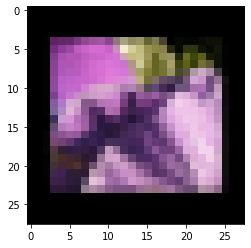

Input image (Up-scale factor 3): 


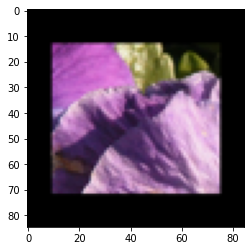

In [8]:
trainExample9 = SuperResolutionDataset("train_data/Set91", 9)
print("Input image (Up-scale factor 9): ")
trainExample9.imshow_input(0)

trainExample3 = SuperResolutionDataset("train_data/Set91", 3)
print("Input image (Up-scale factor 3): ")
trainExample3.imshow_input(0)

Target image: 


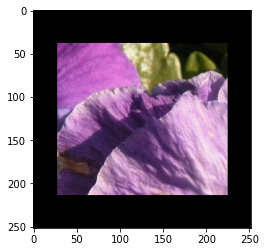

In [9]:
print("Target image: ")
trainExample9.imshow_target(0)

## Network Architecture

In [ ]:
import torch.nn as nn


class SuperResolutionNet(nn.Module):
    def __init__(self, r, l=3, activation=nn.Identity()):
        super().__init__()
        self.l = l
        self.r = r

        self.activation = activation

        self.conv1 = nn.Conv2d(3, 64, 5, padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, self.r * self.r * 3, 3, padding=1)

        self.deconvolution = nn.PixelShuffle(self.r)

        self.params = [self.conv1, self.conv2, self.conv3, self.conv4]

        self.l = l  # The number of hidden layers

    def forward(self, x):
        for i in range(self.l):
            x = self.activation(self.params[i](x))

        x = self.params[self.l](
            x
        )  # Don't use the activation on the last convolutional layer
        x = self.deconvolution(x)

        return x

## Training Network
Function to train a certain network with a certain data loader and hyperparameters

In [25]:
import os
import time

def train(net, use_gpu, train_loader, r,
          learning_rate=0.001,
          max_epochs_without_improvement=100,
          max_epochs=1000,
          print_output=True):

    # Decide to use GPU or not.
    if use_gpu:
        net = net.cuda()
        print('Running on gpu')

    # Set loss function and optimizer.
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Save computer name to use when storing network
    computer_name = os.environ['COMPUTERNAME']

    # Initialize loss.
    lowest_loss = (0, float('inf'))
    highest_psnr = - float('inf')

    begin_time = time.time()
    minimum_psnr_to_save = 20

    # Start training.
    for epoch in range(max_epochs):
        train_loss = []

        # Train and propagate through network.
        net.train()
        for input, target in train_loader:

            optimizer.zero_grad()

            output = net(input)

            loss = loss_function(output, target)

            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

        mean_train_loss = np.mean(train_loss)
        mean_psnr = mse_to_psnr(mean_train_loss)

        # Update the lowest loss if necessary.
        if mean_train_loss < lowest_loss[1]:
            #print(f"Epoch: {epoch: >3} Training Loss: {mean_train_loss:.6f} Mean PSNR: {mean_psnr:.2f} in {time.time() - begin_time:.2f}s #")
            lowest_loss = (epoch, mean_train_loss)
            highest_psnr = mean_psnr

            #If the psnr is above some threshold save this new best network.
            if highest_psnr > minimum_psnr_to_save:
                torch.save(net, f'SuperResulutionNet_best_of_run-{computer_name}')

        if epoch % 100 == 0 and print_output:
            print(
                f"Epoch: {epoch: >3} in {time.time() - begin_time:.2f}s, best epoch so far: Epoch: {epoch: >3} Training Loss: {mean_train_loss:.6f} Mean PSNR: {mean_psnr:.2f}")

        # If we didn't improve for some amount of epoch, lets stop.
        if epoch > lowest_loss[0] + max_epochs_without_improvement:
            if print_output:
                print(f"No improvement for the last {max_epochs_without_improvement} epochs, so stopping training...")
            break

    net.eval()
    if highest_psnr >= minimum_psnr_to_save:
        network_name = f'SuperResulutionNet_r-{r}_psnr-{int(round(highest_psnr * 100))}__mse-{int(round(lowest_loss[1] * 10000))}-{computer_name}'
        old_file = os.path.join(".", f'SuperResulutionNet_best_of_run-{computer_name}')
        new_file = os.path.join(".", network_name)
        if print_output:
            print(f'Saving best epoch ({lowest_loss[0]}) with loss: {lowest_loss[1]} and psnr: {highest_psnr} as:')
            print(network_name)
        os.rename(old_file, new_file)
    elif print_output::
        print("Not high enough psnr to save the network...")

    return lowest_loss[1]

In [ ]:
use_gpu = torch.cuda.is_available()

# Batch size.
bs = 2

# Upscale factor.
r = 3

# Amount of epochs.
epochs = 20

# Getting image data
transform = transforms.Compose([transforms.ToTensor()])  # ,

# Load the training data.
training_set = SuperResolutionDataset("train_data/Set91", r, use_gpu=use_gpu)

train_loader = torch.utils.data.DataLoader(
    training_set, batch_size=bs, shuffle=True, num_workers=0
)

# Initialize the network.
net = SuperResolutionNet(r, activation=nn.ReLU())

train(net, use_gpu, train_loader, r)

Running on gpu
Epoch:   0 in 0.68s, best epoch so far: Epoch:   0 Training Loss: 0.044561 Mean PSNR: 13.51
Epoch: 100 in 77.43s, best epoch so far: Epoch: 100 Training Loss: 0.001736 Mean PSNR: 27.61


## Evaluation

In [123]:
import math

import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from os import listdir

# from SuperResolutionDataset import SuperResolutionDataset
import numpy as np


def imshow(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def evaluate_by_name(network_name):
    net = torch.load(network_name)
    evaluate(net)
    
def evaluate(network):
    r = net.r
    print(f"r: {r}")

    use_gpu = torch.cuda.is_available()

    test_set_paths = ["test_data/" + f for f in listdir("test_data")]
#     test_set_paths = ["test_data/Custom"]

    for path in test_set_paths:
        psnr = []
        test_set = SuperResolutionDataset(path, r, use_gpu=use_gpu, testing=False)


        test_loader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)


        for input, target in iter(test_loader):
            if use_gpu:
                input = input.cuda()
                target = target.cuda()

            if input.size()[1] == 1:
                input = input.repeat(1, 3, 1, 1)

            output = net(input)


            if use_gpu:
                input = input.cpu()
                output = output.cpu()
                target = target.cpu()


            bicubic = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.BICUBIC),
                transforms.ToTensor()
            ])
            bicubic_upscaled = bicubic(input[0])

            nearest_neighbour = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.NEAREST),
                transforms.ToTensor()
            ])

            input = nearest_neighbour(input[0])
            output = torch.clamp(output.detach(), 0, 1)


            if target.size()[1] == 1:
                target = target.repeat(1, 3, 1, 1)

            mse_loss = nn.MSELoss()
            psnr.append(10 * math.log10(1. / mse_loss(output, target).item()))

            images = [input, target[0], output.detach()[0], bicubic_upscaled]

#             imshow(torchvision.utils.make_grid(images))

        print(f"{path} psnr: {np.mean(psnr)}")

    # plt.show()

In [121]:
evaluate(net)

r: 3
test_data/BSD300 psnr: 23.391842096438534
test_data/BSD500 psnr: 23.32647689647426
test_data/Custom psnr: 22.772759494380924
test_data/Set14 psnr: 22.688553209018608
test_data/Set5 psnr: 23.747014425667313
test_data/SuperTexture psnr: 21.186218156106662


In [124]:
evaluate_by_name('SuperResulutionNet_r-3_psnr-3030__mse-10-JORIS-LAPTOP')

r: 3
test_data/BSD300 psnr: 22.764210268052036
test_data/BSD500 psnr: 22.717572154261305
test_data/Custom psnr: 23.86945576995477
test_data/Set14 psnr: 22.25212764313012
test_data/Set5 psnr: 23.606596387170093
test_data/SuperTexture psnr: 21.072878666297683


### Finding Hyperparameters

In [120]:
from ax import optimize

def train_evaluate(parameters):
    use_gpu = torch.cuda.is_available()
    bs = 32
    r = 3

    training_set = SuperResolutionDataset('train_data/Set91', r, use_gpu=use_gpu)
    # training_set = SuperResolutionDataset('test_data/BSD500', r, use_gpu=use_gpu)

    train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=bs, shuffle=True, num_workers=0
    )

    # Initialize the network.
    net = SuperResolutionNet(r, activation=nn.ReLU())

    return train(net, use_gpu, train_loader, r, max_epochs=10, max_epochs_without_improvement=10, learning_rate=parameters['lr'])


best_parameters, best_values, experiment, model = optimize(
        parameters=[
            {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        ],
        # Booth function
        evaluation_function=train_evaluate,
        minimize=True,
    )

print(best_parameters, best_values, experiment, model)

[INFO 04-15 19:05:22] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 04-15 19:05:22] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-15 19:05:22] ax.service.managed_loop: Running optimization trial 1...


Running on gpu
Epoch:   0 in 0.43s, best epoch so far: Epoch:   0 Training Loss: 661.587508 Mean PSNR: -28.21


[INFO 04-15 19:05:26] ax.service.managed_loop: Running optimization trial 2...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.43s, best epoch so far: Epoch:   0 Training Loss: 652323551.025304 Mean PSNR: -88.14


[INFO 04-15 19:05:30] ax.service.managed_loop: Running optimization trial 3...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.46s, best epoch so far: Epoch:   0 Training Loss: 10919.349786 Mean PSNR: -40.38


[INFO 04-15 19:05:35] ax.service.managed_loop: Running optimization trial 4...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.46s, best epoch so far: Epoch:   0 Training Loss: 13.237754 Mean PSNR: -11.22


[INFO 04-15 19:05:40] ax.service.managed_loop: Running optimization trial 5...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.46s, best epoch so far: Epoch:   0 Training Loss: 0.907618 Mean PSNR: 0.42


[INFO 04-15 19:05:44] ax.service.managed_loop: Running optimization trial 6...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.52s, best epoch so far: Epoch:   0 Training Loss: 0.184334 Mean PSNR: 7.34


[INFO 04-15 19:05:51] ax.service.managed_loop: Running optimization trial 7...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.53s, best epoch so far: Epoch:   0 Training Loss: 0.187620 Mean PSNR: 7.27


[INFO 04-15 19:05:57] ax.service.managed_loop: Running optimization trial 8...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.49s, best epoch so far: Epoch:   0 Training Loss: 0.162959 Mean PSNR: 7.88


[INFO 04-15 19:06:04] ax.service.managed_loop: Running optimization trial 9...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.47s, best epoch so far: Epoch:   0 Training Loss: 0.191882 Mean PSNR: 7.17


[INFO 04-15 19:06:11] ax.service.managed_loop: Running optimization trial 10...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.47s, best epoch so far: Epoch:   0 Training Loss: 0.183558 Mean PSNR: 7.36


[INFO 04-15 19:06:18] ax.service.managed_loop: Running optimization trial 11...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.46s, best epoch so far: Epoch:   0 Training Loss: 0.158504 Mean PSNR: 8.00


[INFO 04-15 19:06:25] ax.service.managed_loop: Running optimization trial 12...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.48s, best epoch so far: Epoch:   0 Training Loss: 0.203509 Mean PSNR: 6.91


[INFO 04-15 19:06:31] ax.service.managed_loop: Running optimization trial 13...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.52s, best epoch so far: Epoch:   0 Training Loss: 79.843066 Mean PSNR: -19.02


[INFO 04-15 19:06:38] ax.service.managed_loop: Running optimization trial 14...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.47s, best epoch so far: Epoch:   0 Training Loss: 0.189241 Mean PSNR: 7.23


[INFO 04-15 19:06:44] ax.service.managed_loop: Running optimization trial 15...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.53s, best epoch so far: Epoch:   0 Training Loss: 0.167131 Mean PSNR: 7.77


[INFO 04-15 19:06:51] ax.service.managed_loop: Running optimization trial 16...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.47s, best epoch so far: Epoch:   0 Training Loss: 0.120707 Mean PSNR: 9.18


[INFO 04-15 19:06:58] ax.service.managed_loop: Running optimization trial 17...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.50s, best epoch so far: Epoch:   0 Training Loss: 0.189520 Mean PSNR: 7.22


[INFO 04-15 19:07:05] ax.service.managed_loop: Running optimization trial 18...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.48s, best epoch so far: Epoch:   0 Training Loss: 0.888247 Mean PSNR: 0.51


[INFO 04-15 19:07:11] ax.service.managed_loop: Running optimization trial 19...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.49s, best epoch so far: Epoch:   0 Training Loss: 0.379061 Mean PSNR: 4.21


[INFO 04-15 19:07:18] ax.service.managed_loop: Running optimization trial 20...


Not high enough psnr to save the network...
Running on gpu
Epoch:   0 in 0.52s, best epoch so far: Epoch:   0 Training Loss: 0.189467 Mean PSNR: 7.22
Not high enough psnr to save the network...
{'lr': 0.000809319118385673} ({'objective': 0.022316000075264006}, {'objective': {'objective': 3.0093466393446977e-09}}) SimpleExperiment(None) <ax.modelbridge.torch.TorchModelBridge object at 0x000002259C217D88>
